In [13]:
import sys 
sys.path.insert(-1,"../")
from mazeAgentUtils import *

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Setting parameters
Initialising
   making state/history dataframes
   initialising velocity, position and direction
   setting time/run counters
   making the maze walls
   discretising position for later plotting
   handling undefined parameters
   initialising basis features for learning
   calculating state vector at all discretised positions
   initialising STDP weight matrix and traces


  0%|          | 0/120000 [00:00<?, ?it/s]

../mazeAgentUtils.py:778: RuntimeWarning: overflow encountered in exp
  state[distance<self.sigmas] += np.e * np.exp(-1/(1-(distance/self.sigmas)**2))[distance<self.sigmas]


Calculating place and grid cells


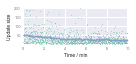

In [18]:
N=50
xcen = np.linspace(0,5,N+1)[:-1]
xcen += (xcen[1] - xcen[0]) / 2
ycen = np.array([0.1]*N)
centres = np.vstack((xcen,ycen)).T


params = { 
          'mazeType'           : 'loop',  #type of maze, define in getMaze() function
          'stateType'          : 'bump', #feature on which to TD learn (onehot, gaussian, gaussianCS, fourier, circles)
          'movementPolicy'     : 'windowsScreensaver',  #movement policy (raudies, random walk, windows screensaver)
          'roomSize'           : 5,          #maze size scaling parameter, metres
          'dt'                 : 0.005,       #simulation time disretisation 
          'dx'                 : 0.01,       #space discretisation (for plotting, movement is continuous)
          'tau'                : 4,          #TD decay time, seconds
          'TDdx'               : 0.01,       #rough distance between TD learning updates, metres 
          'alpha'              : 0.01,       #TD learning rate 
          'nCells'             : 50,       #how many features to use
          'centres'            : centres,       #array of receptive field positions. Overwrites nCells
          'speedScale'         : 0.16,       #movement speed scale, metres/second
          'rotSpeedScale'      : 2*np.pi,       #rotational speed scale, radians/second
          'initPos'            : None,       #initial position [x0, y0], metres
          'initDir'            : None,       #initial direction, unit vector
          'sigma'              : 1,        #feature cell width scale, relevant for  gaussin, gaussianCS, circles
          'doorsClosed'        : False,       #whether doors are opened or closed in multicompartment maze
          'successorFeatureNorm':100                 
}

agent =  MazeAgent(params)
agent.pos, agent.dir = np.array([0.101,0.1]), np.array([1,0])
agent.runRat(10)

(<Figure size 1440x57.6 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f91232822b0>)

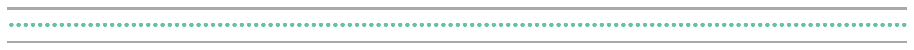

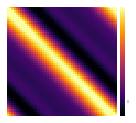

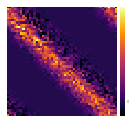

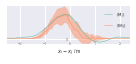

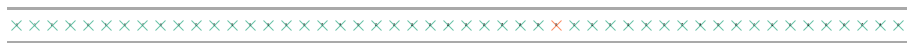

In [20]:
%matplotlib inline
plotter = Visualiser(agent)
plotter.plotTrajectory(starttime=0, endtime=agent.t/60, skiprate=100)
plotter.plotM()
plotter.plotM(STDP=True)
M_copy = plotter.plotMAveraged()
plotter.plotFeatureCells(centresOnly=True)
# plt.imshow(M_copy)

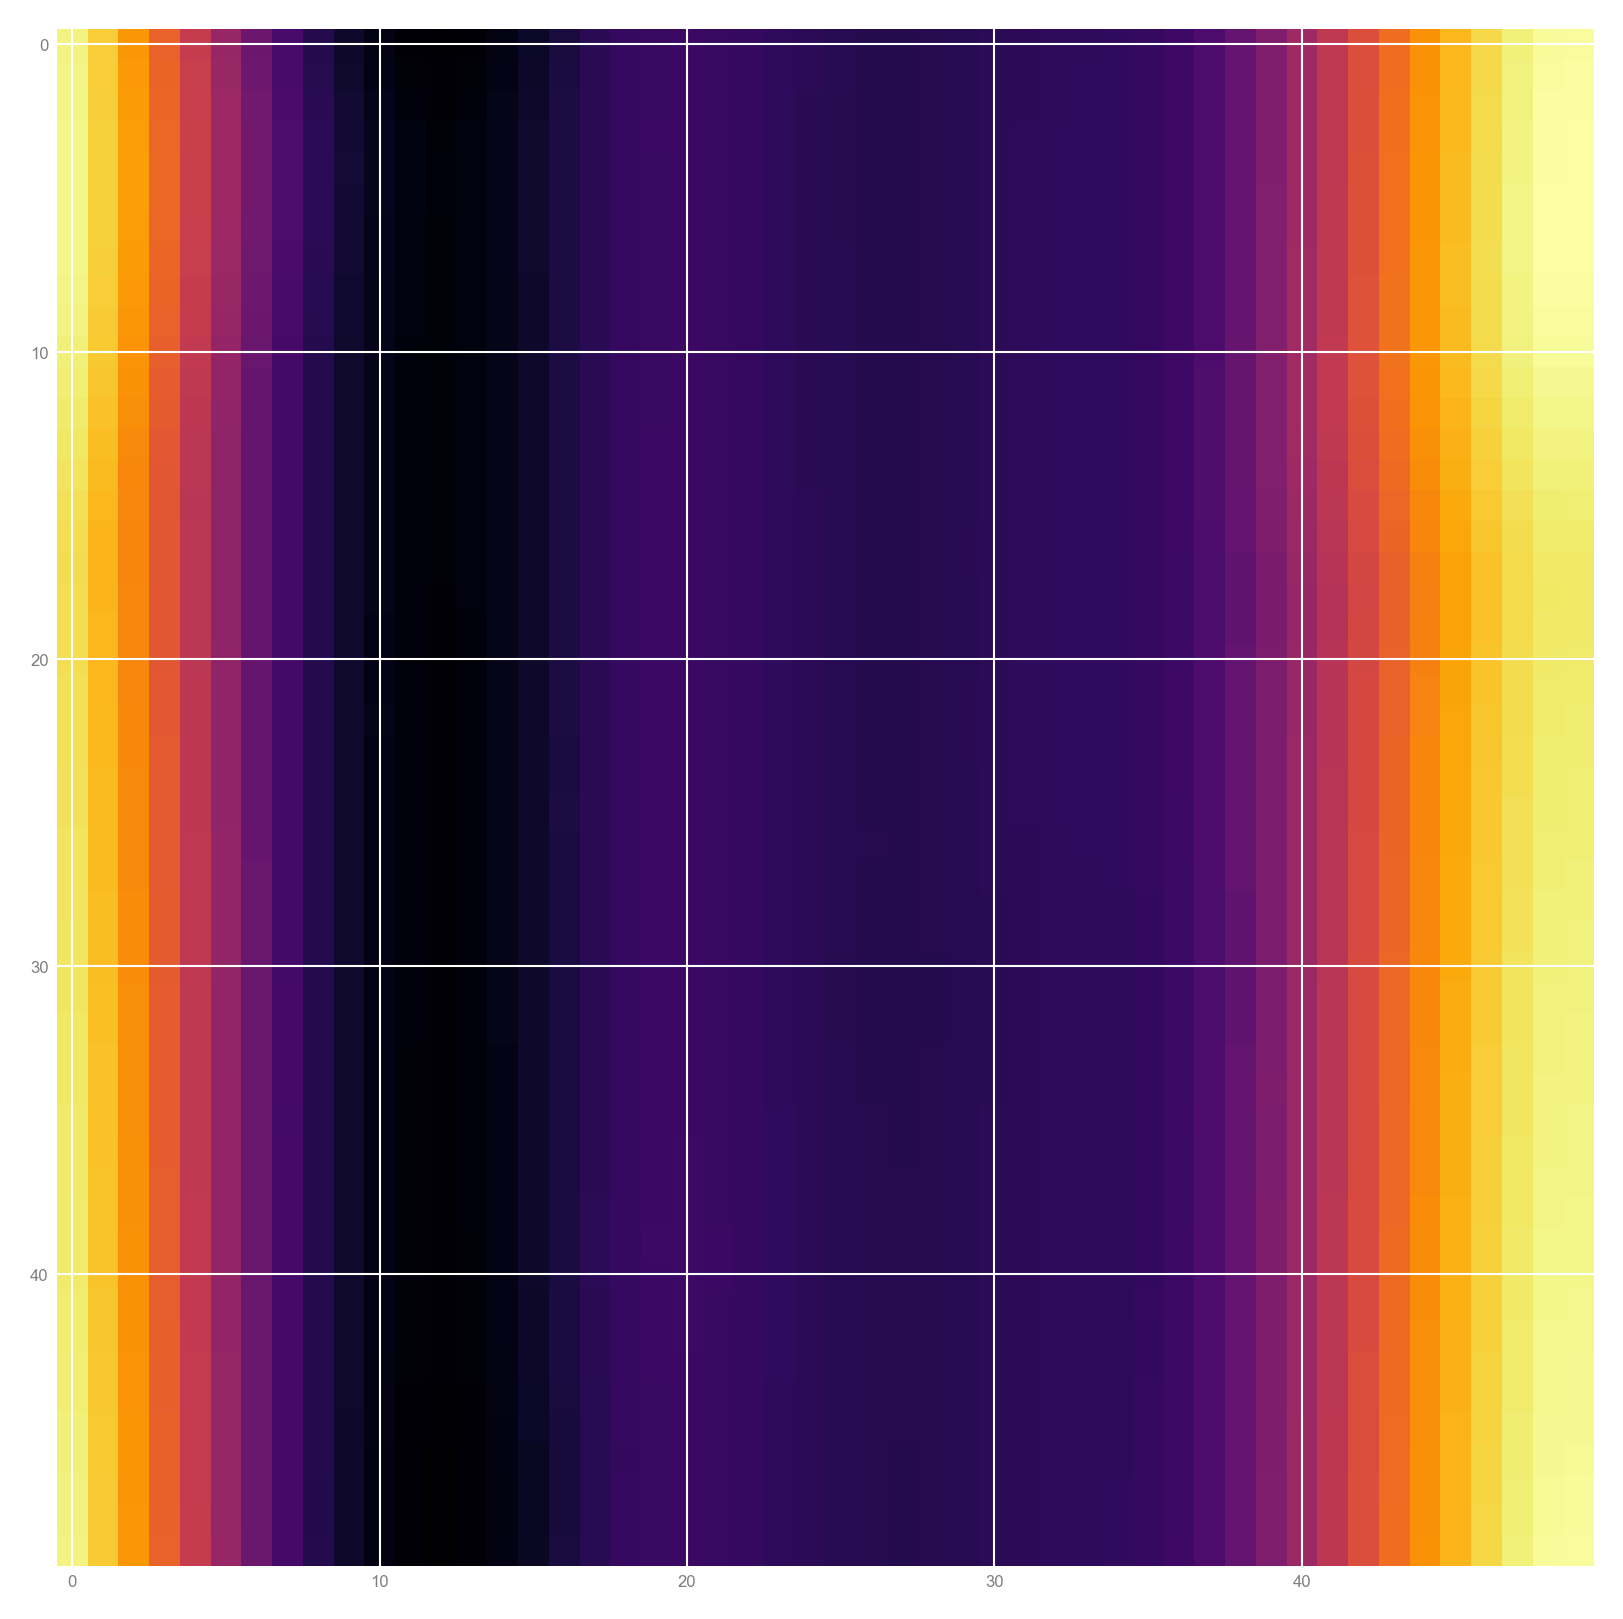

In [ ]:
plt.imshow(M_copy)

In [ ]:
agent.pos = np.array([0,0.1])
agent.dir = np.array([1,0])
# agent.runRat(trainTime=60,STDPLearn=True,TDSRLearn=False,saveEvery=1)

plotter = Visualiser(agent)
plotter.plotM(STDP=True,colorbar=True)
plotter.plotPlaceField(hist_id=-1,number=15,STDP=False)
plotter.plotPlaceField(hist_id=-1,number=15,STDP=True)
plotter.plotSTDPFiringRates(starttime=1,endtime=1+1/60)

In [ ]:
w = agent.W.T.copy()
for i in range(50):
    w[i,:] = np.roll(w[i,:],-i+25)
plotter.plotM(M=agent.W.T)
plotter.plotM(M=w)
mean = np.mean(w,axis=0)
std = np.std(w,axis=0)
fig, ax = plt.subplots(figsize=(2,1))
x = xcen - 2.55
ax.plot(x,mean)
ax.fill_between(x,mean + std,mean - std, alpha=0.5)
ax.set_xlabel('Distance from centre cell')
ax.set_ylabel('$M_{ij}$ strength')
saveFigure(fig,'w_cross',transparent=False)

In [ ]:
#TD SR 
roomSize = 5
N=roomSize*10
xcen = np.linspace(0,roomSize,N+1)[:-1]
xcen += (xcen[1] - xcen[0]) / 2
ycen = np.array([0.1]*N)
centres = np.vstack((xcen,ycen)).T

params = { 
          'mazeType'            : 'loop',  #type of maze, define in getMaze() function
          'stateType'           : 'gaussian', #feature on which to TD learn (onehot, gaussian, gaussianCS, fourier, circles)
          'movementPolicy'      : 'windowsScreensaver',  #movement policy (raudies, random walk, windows screensaver)
          'roomSize'            : roomSize,          #maze size scaling parameter, metres
          'dt'                  : 0.1,       #simulation time disretisation 
          'dx'                  : 0.01,       #space discretisation (for plotting, movement is continuous)
          'tau'                 : 5,          #TD decay time, seconds
          'TDdx'                : 0.001,       #rough distance between TD learning updates, metres 
          'alpha'               : 0.01,       #TD learning rate 
          'nCells'              : N,       #how many features to use
          'cellFiringRate'      : 10,         #peak firing rate of a cell (middle of place field, preferred theta phase)
          'centres'             : centres,       #array of receptive field positions or onehotd. Overwrites nCells
          'speedScale'          : 0.16,       #movement speed scale, metres/second
          'rotSpeedScale'       : 0.1,       #rotational speed scale, radians/second
          'initPos'             : None,       #initial position [x0, y0], metres
          'initDir'             : None,       #initial direction, unit vector
          'sigma'               : 0.6,        #feature cell width scale, relevant for  gaussin, gaussianCS, circles
          'doorsClosed'         : False,       #whether doors are opened or closed in multicompartment maze
          'successorFeatureNorm': 1/10
}


agent_TD =  MazeAgent(params)
plotter = Visualiser(agent_TD)
agent_TD.toggleDoors(params['doorsClosed'])
plotter.plotFeatureCells()
# for i in [1,15,13]:
#     plotter.plotReceptiveField(i)
#     plotter.plotPlaceField(number=i)
agent_TD.pos = np.array([0.01,0.1])
agent_TD.dir = np.array([1,0])


In [ ]:
agent_TD.runRat(trainTime=60,STDPLearn=False,TDSRLearn=True,saveEvery=None,TDlearnorder='everystep')
plotter = Visualiser(agent_TD)
# plotter.plotM(M=np.maximum(0,agent_TD.M),STDP=False)
plotter.plotM(M=agent_TD.M,STDP=False)
for i in [1,15,30]:
    plotter.plotPlaceField(number=i,hist_id=0)
    plotter.plotPlaceField(number=i)

In [ ]:
agent_TD.pos

In [ ]:
scipy.special.erf(1)

In [ ]:
#linear regression solution
left, right = -5,5
N_data = 10000
N_centres = 100
sigma = 1.5
tau = 10
v = 0.16
lam = 0.2

x = np.linspace(left,right,N_data)
centres = np.linspace(left,right,N_centres)

X = np.zeros((N_data,N_centres))
Y = np.zeros((N_data,1))

def analytic_solution(x,sigma=1,tau=10,v=0.16):
    z = (x/(np.sqrt(2)*sigma)) + sigma/(2*v*tau)
    return (1 - scipy.special.erf(z)) * np.exp(x/(v*tau))

def gaussian(x,centres,sigma=0.5):
    devs = (centres - x)**2
    return np.exp(-devs / (2*(sigma**2)))

for (i,x_) in enumerate(x):
    X[i,:] = gaussian(x_,centres,sigma)
    Y[i] = analytic_solution(x_,sigma,tau,v)

W = np.matmul(np.linalg.inv(np.matmul(X.T,X) + lam*np.identity(N_centres)),np.matmul(X.T,Y))


def reproduced_analytic(x,W,centres):
    y = 0
    for (i,w) in enumerate(W):
        y += w * gaussian(x,centres[i],sigma)
    return y

y_reproduced = np.zeros(N_data)
y_true = Y[:,0]
for i in range(len(y_reproduced)):
    y_reproduced[i] = reproduced_analytic(x[i],W,centres)


fig,ax = plt.subplots(2,1,figsize=(2,2))
ax[0].plot(centres,W)
ax[0].set_xlabel('Basis cell centre location')
ax[0].set_ylabel('Basis cell weight, $M_{ij}$')
ax[0].set_title('N basis cells = %g' %N_centres)

ax[1].plot(x,y_reproduced,C='C1',label='Reproduced')
ax[1].plot(x,y_true,C='C2',label='True')
ax[1].set_xlabel('x')
ax[1].set_title('Successor feature')
ax[1].legend()

saveFigure(fig,'truevsreproduced',transparent=False)


In [ ]:
np.linalg.inv(a)

In [ ]:
fig, ax = plt.subplots(figsize=(2,1))
ax.plot(agent_TD.M[25,:])
saveFigure(fig,'Mcross')